In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/annotation/final_labels.csv', index_col=0)

## Log Reg over lemmatized text

In [3]:
df

,Emotion,Dehumanization,Mention,External ID,Created By,text,rating
1219,"так, присутня негативна",так,так,row_0.txt,snizannabotvin@gmail.com,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",4
1218,"ні, оцінка не присутня",ні,ні,row_1.txt,snizannabotvin@gmail.com,Литературный критик Галина Юзефович о новом ро...,4
1591,"так, присутня негативна",так,так,row_10.txt,snizannabotvin@gmail.com,Почему на базах неонацистов стоят языческие ис...,4
1198,"так, присутня негативна",так,так,row_100.txt,snizannabotvin@gmail.com,Группа добровольцев-медиков из Чеченской Респу...,4
3247,"ні, оцінка не присутня",ні,так,row_1000.txt,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5
...,...,...,...,...,...,...,...
3613,"ні, оцінка не присутня",ні,так,row_995.txt,tutovadesign@gmail.com,Утренний брифинг Минобороны России: ▪️ россий...,5
3612,"так, присутня негативна",ні,так,row_996.txt,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5
4121,"так, присутня негативна",ні,так,row_997.txt,yevhen.marchenko91@gmail.com,Наш соратник по русскому движению Алексей Сели...,3
4120,"ні, оцінка не присутня",так,так,row_998.txt,yevhen.marchenko91@gmail.com,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,3


In [4]:
df_dehumanization = df[['Dehumanization', 'text']].reset_index(drop=True)

In [5]:
df_dehumanization['label'] = df_dehumanization['Dehumanization'].apply(lambda x: 0 if x=='ні' else 1)

In [6]:
df_dehumanization

,Dehumanization,text,label
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1
1,ні,Литературный критик Галина Юзефович о новом ро...,0
2,так,Почему на базах неонацистов стоят языческие ис...,1
3,так,Группа добровольцев-медиков из Чеченской Респу...,1
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0
...,...,...,...
3541,ні,Утренний брифинг Минобороны России: ▪️ россий...,0
3542,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0
3543,ні,Наш соратник по русскому движению Алексей Сели...,0
3544,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1


## Preprocessing

In [7]:
import spacy
nlp = spacy.load('ru_core_news_md',disable=['ner', 'attribute_ruler'])

def lemmatize_spacy(text):
    doc = nlp(text)
    result = " ".join([token.lemma_ for token in doc])
    return result

In [8]:
cyrillic_letters = u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ "

def clean_text(string, allowed_symbols):
    getVals = list(filter(lambda x: x in allowed_symbols, string))
    result = "".join(getVals)
    return result

In [16]:
def preprocess_df(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
    df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
    df=df[df['text_clean']!='']
    df.reset_index(inplace=True)
    return df

In [10]:
%%time
df_dehumanization = preprocess_df(df_dehumanization)

CPU times: user 18.8 s, sys: 199 ms, total: 19 s
Wall time: 19.3 s


## Logreg

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_, X_test_, y_train, y_test = train_test_split(df_dehumanization["text_clean"], df_dehumanization["label"], test_size=0.2, random_state=42)

In [12]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_)
X_test = vectorizer.transform(X_test_)

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.82
Recall: 0.71
F1 Score: 0.77


### Gridsearch

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

logreg_best = grid_search.best_estimator_

logreg_best.fit(X_train, y_train)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [22]:
y_pred = logreg_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.80
Precision: 0.79
Recall: 0.77
F1 Score: 0.78


In [23]:
best_params = logreg_best.get_params()
print("Best hyperparameters for the logistic regression model:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


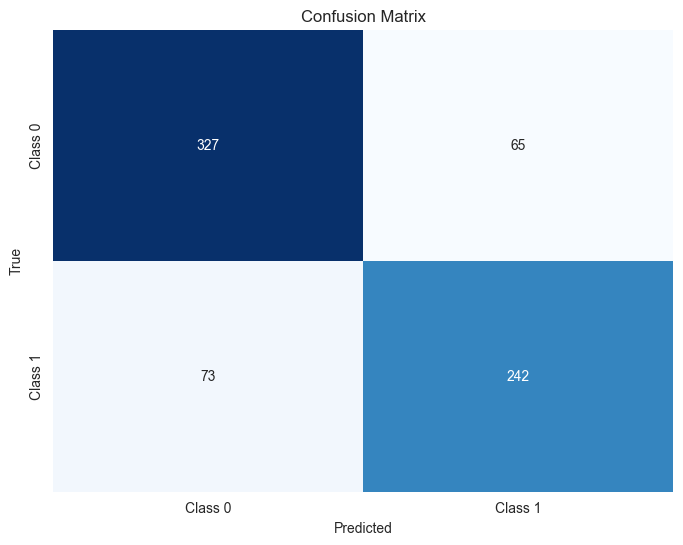

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
original_data = df_dehumanization.loc[X_test_.index]

In [26]:
original_data['Predicted Label'] = y_pred
original_data['Prediction Status'] = original_data['label'] == original_data['Predicted Label']
incorrect_predictions = original_data[~original_data['Prediction Status']]

In [27]:
print("Incorrectly predicted samples:")
for index, row in incorrect_predictions.iterrows():
    print(f"Index: {index}\nOriginal Text: {row['text']}\nTrue Label: {row['label']}\nPredicted Label: {row['Predicted Label']}\n")

Incorrectly predicted samples:
Index: 2902
Original Text: Кадыров: «Мариуполь в ближайшее время будет полностью очищен от бандеровщины и шайтанов.
True Label: 1
Predicted Label: 0

Index: 2412
Original Text: Половцы и печенеги только о себе думают;)
True Label: 0
Predicted Label: 1

Index: 495
Original Text: "Вот так мы живэм! Вот так нас кинули, а сами поехали в Запорожье"  У укровояки накипело.
True Label: 1
Predicted Label: 0

Index: 679
Original Text: Чтобы статистикой в миллионы россиян, приехавших в Крым, раз и навсегда разбить в клочья любые потуги русофобов и свидомых на тему сорванных туристических сезонов в Крыму.
True Label: 0
Predicted Label: 1

Index: 2562
Original Text: А какие это ваши условия? Сложите оружие, отдайте границу, все в тюрьму, мы введём свою администрацию из галичан, всех вас через фильтрационный лагерь, Бандеру в каждый дом, и жизни вас научим?   Вы там реально все примороженные? Вы реально думаете, что в ЛДНР все мечтают извиниться перед вами, покаяться и

### Preliminary error analysis

Укрвояки сприймається системою як дегуманізація

Рядок 2562, 2210, 1288, 1188, 291, 2486 - сумнівний лейбл, цілком можливо що система права

Хохлофейки тригерить систему

Чомусь тригерить коронавірус (93, 33)

Не впізнає місцями свинорейх (як в 3419, 170)

Майже весь неонацизм постійно тригерить систему - 2775, 1011, 289 (але от в 2320 - неонацизм как раковая опухоль - ні, 3193 - )

1070 - система тригериться на чубатих

Система гірше зчитує subtle cues - 554 (накапливаются), 2335 (зондероотряд), 486 (не бандероукропианці, а держава = навоз), 2646 (опис а не фразеологізм)

Не всі атрибути нацизма впізнає - 678 (бандерюгенд), 2335 (зондероотряд), 2293 (бандерофашисти)

2086 - укропские мартішки




## Log Reg over lemmatized text plus (or exclusively) collocations (with concatenaction)

In [20]:
from collocation_extraction import collect_verb_obl_obj, collect_core, collect_nmod, collect_amod, collect_comp, collect_appos, show_dependency, lst_to_str

In [35]:
df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_dehumanization['nmod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_dehumanization['amod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_amod(x)))
df_dehumanization['comp'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_comp(x)))

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_11257/1996300300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_11257/1996300300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
/var/folders/2w/hygxgpp5353_dy_t

In [36]:
df_dehumanization.drop(columns='index', inplace=True)

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_11257/2166550837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization.drop(columns='index', inplace=True)


In [37]:
df_dehumanization

,Dehumanization,text,label,text_clean,text_lemmatized,core_noun_verb,verb_obl_obj,nmod,amod,comp
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1,всвязи с этим немного поправлю коллег они не...,всвязи с это немного поправить коллега они ...,"Всвязи немного поправлю, Они не начинать, мы д...","немного поправлю коллег, не начинать армагеддо...","Всвязи с этим, диверсии в Польше, удар ТЯО, уд...","ядерный армагеддон, осознанный удар, Львовской...",
1,ні,Литературный критик Галина Юзефович о новом ро...,0,литературный критик галина юзефович о новом ро...,литературный критик галина юзефович о новый ро...,"критик все состоит, достоинство все состоит, э...","состоит в том, захватывающе читать которую","критик петербуржца романе, романе петербуржца,...","Литературный критик, новом романе, Главное дос...",
2,так,Почему на базах неонацистов стоят языческие ис...,1,почему на базах неонацистов стоят языческие ис...,почему на база неонацист стоять языческий исту...,истуканы Почему стоят,Почему стоят на базах,"базах неонацистов, Гость студии, протоиерей СМ...",языческие истуканы,
3,так,Группа добровольцев-медиков из Чеченской Респу...,1,группа добровольцевмедиков из чеченской респуб...,группа добровольцевмедиков из чеченский респуб...,"Группа наравне вносит, врачи оказывают","вносит лепту, вносит в дело, вносит -, вносит ...","Группа добровольцев, Группа -, Группа медиков,...","бандеровских мразей, подлых шайтанов, Республи...",
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0,всушники переходите на сторону добра у нас теп...,всушники переходить на сторона добро у нас тёп...,"ВСУшники переходите, тепло нас",переходите на сторону,сторону добра,вкусные печеньки,
...,...,...,...,...,...,...,...,...,...,...
3526,ні,Утренний брифинг Минобороны России: ▪️ россий...,0,утренний брифинг минобороны россии российски...,утренний брифинг минобороны россия российск...,"брифинг продвинулись, силы продвинулись, групп...","продвинулись за ночь, продвинулись на км, разв...","брифинг Минобороны, наступление бригады подраз...","Утренний брифинг, российские силы, украинской ...",
3527,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0,и понеслась мазепинщинопетлюровщинобандеровщина,и понестись мазепинщинопетлюровщинобандеровщина,,"понеслась петлюровщино, понеслась -, понеслась...",,,
3528,ні,Наш соратник по русскому движению Алексей Сели...,0,наш соратник по русскому движению алексей сели...,наш соратник по русский движение алексей селив...,соратник вместе прибыл,"прибыл в область, создавать органы, создавать ...","соратник русскому движению, армией России, орг...","русскому движению, Запорожскую область, мирной...",
3529,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1,хорошее видео от бригады нм лнр обработка по...,хороший видео от бригада нм лнр обработка ...,,,"видео НМ бригады, бригады НМ, обработка позици...","Хорошее видео, пифтонными бомбами",


In [38]:
df_dehumanization

,Dehumanization,text,label,text_clean,text_lemmatized,core_noun_verb,verb_obl_obj,nmod,amod,comp
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1,всвязи с этим немного поправлю коллег они не...,всвязи с это немного поправить коллега они ...,"Всвязи немного поправлю, Они не начинать, мы д...","немного поправлю коллег, не начинать армагеддо...","Всвязи с этим, диверсии в Польше, удар ТЯО, уд...","ядерный армагеддон, осознанный удар, Львовской...",
1,ні,Литературный критик Галина Юзефович о новом ро...,0,литературный критик галина юзефович о новом ро...,литературный критик галина юзефович о новый ро...,"критик все состоит, достоинство все состоит, э...","состоит в том, захватывающе читать которую","критик петербуржца романе, романе петербуржца,...","Литературный критик, новом романе, Главное дос...",
2,так,Почему на базах неонацистов стоят языческие ис...,1,почему на базах неонацистов стоят языческие ис...,почему на база неонацист стоять языческий исту...,истуканы Почему стоят,Почему стоят на базах,"базах неонацистов, Гость студии, протоиерей СМ...",языческие истуканы,
3,так,Группа добровольцев-медиков из Чеченской Респу...,1,группа добровольцевмедиков из чеченской респуб...,группа добровольцевмедиков из чеченский респуб...,"Группа наравне вносит, врачи оказывают","вносит лепту, вносит в дело, вносит -, вносит ...","Группа добровольцев, Группа -, Группа медиков,...","бандеровских мразей, подлых шайтанов, Республи...",
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0,всушники переходите на сторону добра у нас теп...,всушники переходить на сторона добро у нас тёп...,"ВСУшники переходите, тепло нас",переходите на сторону,сторону добра,вкусные печеньки,
...,...,...,...,...,...,...,...,...,...,...
3526,ні,Утренний брифинг Минобороны России: ▪️ россий...,0,утренний брифинг минобороны россии российски...,утренний брифинг минобороны россия российск...,"брифинг продвинулись, силы продвинулись, групп...","продвинулись за ночь, продвинулись на км, разв...","брифинг Минобороны, наступление бригады подраз...","Утренний брифинг, российские силы, украинской ...",
3527,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0,и понеслась мазепинщинопетлюровщинобандеровщина,и понестись мазепинщинопетлюровщинобандеровщина,,"понеслась петлюровщино, понеслась -, понеслась...",,,
3528,ні,Наш соратник по русскому движению Алексей Сели...,0,наш соратник по русскому движению алексей сели...,наш соратник по русский движение алексей селив...,соратник вместе прибыл,"прибыл в область, создавать органы, создавать ...","соратник русскому движению, армией России, орг...","русскому движению, Запорожскую область, мирной...",
3529,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1,хорошее видео от бригады нм лнр обработка по...,хороший видео от бригада нм лнр обработка ...,,,"видео НМ бригады, бригады НМ, обработка позици...","Хорошее видео, пифтонными бомбами",


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def get_logreg_best(col_list = ['text_lemmatized'], df=df_dehumanization, vectorizer = TfidfVectorizer(), random_state=42):
    df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
    X_train_, X_test_, y_train, y_test = train_test_split(df["merged_col"], df["label"], test_size=0.2, random_state=random_state)
    X_train = vectorizer.fit_transform(X_train_)
    X_test = vectorizer.transform(X_test_)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    grid_search = GridSearchCV(LogisticRegression(solver='liblinear', random_state=random_state), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    logreg_best = grid_search.best_estimator_
    logreg_best.fit(X_train, y_train)
    y_pred = logreg_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    best_params = logreg_best.get_params()
    print("Best hyperparameters for the logistic regression model:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

In [34]:
get_logreg_best()

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.80
Precision: 0.78
Recall: 0.76
F1 Score: 0.77
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


In [35]:
get_logreg_best(col_list=['text_clean'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.80
Precision: 0.79
Recall: 0.77
F1 Score: 0.78
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
get_logreg_best(col_list=['core_noun_verb'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.65
Precision: 0.67
Recall: 0.42
F1 Score: 0.52
Best hyperparameters for the logistic regression model:
C: 1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [37]:
get_logreg_best(col_list=['verb_obl_obj'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.62
Precision: 0.58
Recall: 0.50
F1 Score: 0.54
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
get_logreg_best(col_list=['nmod'])


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.67
Precision: 0.68
Recall: 0.50
F1 Score: 0.58
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
get_logreg_best(col_list=['amod'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.59
Precision: 0.56
Recall: 0.41
F1 Score: 0.47
Best hyperparameters for the logistic regression model:
C: 100
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [40]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.71
Precision: 0.69
Recall: 0.65
F1 Score: 0.67
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.77
Precision: 0.77
Recall: 0.67
F1 Score: 0.72
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


In [42]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod'])


/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.76
Precision: 0.77
Recall: 0.66
F1 Score: 0.71
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


In [43]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_clean'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: Conve

Accuracy: 0.80
Precision: 0.80
Recall: 0.74
F1 Score: 0.77
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [44]:
get_logreg_best(col_list=['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean'])

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_23733/85191952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'merged_col'] = df[col_list].apply(lambda x: ' '.join(x.astype(str)), axis=1)


Accuracy: 0.81
Precision: 0.81
Recall: 0.77
F1 Score: 0.79
Best hyperparameters for the logistic regression model:
C: 10
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l1
random_state: 42
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False


In [45]:
df_dehumanization.columns

Index(['Dehumanization', 'text', 'label', 'text_clean', 'text_lemmatized',
       'core_noun_verb', 'verb_obl_obj', 'nmod', 'amod', 'comp', 'merged_col'],
      dtype='object')

## Log Reg over lemmatized text plus (or exclusively) collocations (as separate features)

In [62]:
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        self.vectorizers = [TfidfVectorizer(**kwargs) for _ in columns]
        self.fitted_models = []

    def fit(self, X, y=None):
        for col, vec in zip(self.columns, self.vectorizers):
            vec.fit(X[col])
            self.fitted_models.append(vec.fit(X[col]))
        return self

    def transform(self, X):
        features = []
        for col, vec in zip(self.columns, self.vectorizers):
            features.append(vec.transform(X[col]))
        return hstack(features)


def train_logistic_regression(data, text_columns, label_column, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)
    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('regressor', LogisticRegression(solver='liblinear', random_state=random_state, max_iter=100))
    ])

    param_grid = {
        'regressor__fit_intercept': [True, False],
        'regressor__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
        'regressor__penalty': ['l1', 'l2']
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    logreg_best = grid_search.best_estimator_
    logreg_best.fit(X_train, y_train)

    y_pred = logreg_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return logreg_best

In [63]:
text_columns = ['nmod', 'verb_obl_obj']
label_column = ['label']

In [64]:
%%time
trained_pipeline = train_logistic_regression(df_dehumanization, text_columns, label_column)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

Accuracy: 0.69
Precision: 0.64
Recall: 0.70
F1 Score: 0.67
CPU times: user 1min 9s, sys: 35.9 s, total: 1min 45s
Wall time: 36.2 s


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
%%time
text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

trained_pipeline = train_logistic_regression(df_dehumanization, text_columns, label_column)

Accuracy: 0.80
Precision: 0.80
Recall: 0.73
F1 Score: 0.76
CPU times: user 2min 8s, sys: 1min 7s, total: 3min 16s
Wall time: 55.1 s


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Feature importance

### Feature importance of unique vectors

In [66]:
def get_feature_names(vectorizer):
    feature_names = []
    for col, vec in zip(vectorizer.columns, vectorizer.vectorizers):
        feature_names.extend([f"{col}_{f}" for f in vec.get_feature_names_out()])
    return feature_names

In [70]:
import numpy as np
def display_feature_importance(pipeline, n=10):
    vectorizer = pipeline.named_steps['vectorizer']
    classifier = pipeline.named_steps['regressor']
    feature_names = get_feature_names(vectorizer)
    coefficients = classifier.coef_[0]
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    print(f"Top {n} important features:")
    for i in sorted_indices[:n]:
        print(f"{feature_names[i]}: {coefficients[i]}")

In [71]:
display_feature_importance(trained_pipeline)

Top 10 important features:
text_lemmatized_неонацист: 37.31732392323049
text_lemmatized_укрорейха: 35.75365014764923
text_lemmatized_укронацистов: 33.16137008466515
text_lemmatized_укрорейх: 27.337412926848266
text_lemmatized_салорейха: 23.34181189173052
text_lemmatized_укронацистами: 22.64934496311819
text_lemmatized_укронацистам: 21.71354974383657
text_lemmatized_укронацистской: 20.22199264712063
text_lemmatized_шайтан: 20.082047366734663
text_lemmatized_неонацистский: 19.107502130826365


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

tfidf_vectorizer = TfidfVectorizer(max_features=10000)

top_features = pd.DataFrame()

# looping over each text column and apply TF-IDF vectorization followed by chi-squared test
for col in text_columns:
    tfidf_features = tfidf_vectorizer.fit_transform(df_dehumanization[col])

    # chi-squared test to select the top-k features with the lowest p-values
    selector = SelectKBest(chi2, k=100)
    selector.fit(tfidf_features, df_dehumanization['label'])
    feature_scores = pd.DataFrame({
        'feature': tfidf_vectorizer.get_feature_names_out(),
        'p_value': selector.pvalues_,
    })

    # sorting the features by p-value and add the top-k features to the top_features
    top_k_features = feature_scores.sort_values(by='p_value').head(100)['feature']
    top_features[col] = top_k_features

final_features = pd.concat([top_features[col] for col in top_features.columns]).unique().tolist()

In [73]:
final_features

['укронацистов',
 'укрорейха',
 'неонацистов',
 'чубайса',
 'укропитеков',
 'донецка',
 'всушников',
 'укронацисты',
 'салорейха',
 'президента',
 'нацистов',
 'москве',
 'обстрела',
 'хохлорейха',
 'укронациста',
 'шайкой',
 'города',
 'пропаганды',
 'горловки',
 'боевиков',
 'свинособаки',
 'оружия',
 'коронавируса',
 'укронацизма',
 'неонацистами',
 'мид',
 'укрорейхом',
 'наркоманов',
 'свинорейха',
 'хозяева',
 'позициям',
 'бригады',
 'укронациков',
 'укронацистами',
 'подразделений',
 'перемога',
 'укрорейху',
 'жизней',
 'атаки',
 'укровермахта',
 'задача',
 'обстрелы',
 'рублей',
 'укрорейхе',
 'их',
 'захвата',
 'нациков',
 'новостей',
 'координаты',
 'рядах',
 'смерти',
 'позиции',
 'дислокации',
 'бандеровцами',
 'представитель',
 'лица',
 'атаку',
 'неонацисты',
 'коронавирусом',
 'работа',
 'года',
 'режима',
 'просвещения',
 'стиле',
 'склады',
 'рождения',
 'жители',
 'утилизации',
 'хунты',
 'случаев',
 'воевать',
 'командование',
 'новости',
 'тактике',
 'рейха',
 'ме

In [84]:
df = pd.DataFrame(final_features, columns=['final_features'])
df.to_json('most_important_features.json')

## Importance of columns (ie collocations and versions of pre-processing)


### Averaged importance

In [74]:
def get_average_importance(trained_pipeline):
    multi_column_tfidf_vectorizer = trained_pipeline.named_steps['vectorizer']
    logistic_regression = trained_pipeline.named_steps['regressor']
    coef = logistic_regression.coef_

    column_importance = pd.DataFrame()
    start = 0
    for i, col in enumerate(multi_column_tfidf_vectorizer.columns):
        vec = multi_column_tfidf_vectorizer.fitted_models[i]
        end = start + len(vec.get_feature_names_out())
        feature_scores = pd.DataFrame({
            'feature': vec.get_feature_names_out(),
            'importance': abs(coef[0][start:end])
        })
        column_importance[col] = feature_scores.set_index('feature')['importance']
        start = end

    mean_importance = column_importance.mean(axis=0).sort_values(ascending=False)
    return mean_importance

In [75]:
mean_importance = get_average_importance(trained_pipeline)
print(mean_importance)

text_lemmatized    0.309536
core_noun_verb     0.167114
amod               0.130163
nmod               0.097857
verb_obl_obj       0.049938
text_clean         0.015135
dtype: float64


### Importance of columns by permutation

In [18]:
from itertools import combinations, chain

text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

all_col_variations = list(chain.from_iterable(combinations(text_columns, r) for r in range(1, len(text_columns)+1)))
all_col_variations = [list(p) for p in all_col_variations]
all_col_variations

[['nmod'],
 ['verb_obl_obj'],
 ['core_noun_verb'],
 ['amod'],
 ['text_lemmatized'],
 ['text_clean'],
 ['nmod', 'verb_obl_obj'],
 ['nmod', 'core_noun_verb'],
 ['nmod', 'amod'],
 ['nmod', 'text_lemmatized'],
 ['nmod', 'text_clean'],
 ['verb_obl_obj', 'core_noun_verb'],
 ['verb_obl_obj', 'amod'],
 ['verb_obl_obj', 'text_lemmatized'],
 ['verb_obl_obj', 'text_clean'],
 ['core_noun_verb', 'amod'],
 ['core_noun_verb', 'text_lemmatized'],
 ['core_noun_verb', 'text_clean'],
 ['amod', 'text_lemmatized'],
 ['amod', 'text_clean'],
 ['text_lemmatized', 'text_clean'],
 ['nmod', 'verb_obl_obj', 'core_noun_verb'],
 ['nmod', 'verb_obl_obj', 'amod'],
 ['nmod', 'verb_obl_obj', 'text_lemmatized'],
 ['nmod', 'verb_obl_obj', 'text_clean'],
 ['nmod', 'core_noun_verb', 'amod'],
 ['nmod', 'core_noun_verb', 'text_lemmatized'],
 ['nmod', 'core_noun_verb', 'text_clean'],
 ['nmod', 'amod', 'text_lemmatized'],
 ['nmod', 'amod', 'text_clean'],
 ['nmod', 'text_lemmatized', 'text_clean'],
 ['verb_obl_obj', 'core_noun_

In [77]:
class MultiColumnTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        self.vectorizers = [TfidfVectorizer(**kwargs) for _ in columns]
        self.fitted_models = []

    def fit(self, X, y=None):
        for col, vec in zip(self.columns, self.vectorizers):
            vec.fit(X[col])
            self.fitted_models.append(vec.fit(X[col]))
        return self

    def transform(self, X):
        features = []
        for col, vec in zip(self.columns, self.vectorizers):
            features.append(vec.transform(X[col]))
        return hstack(features)


def train_logistic_regression(data, text_columns, label_column, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)
    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('regressor', LogisticRegression(solver='liblinear', random_state=random_state, max_iter=100))
    ])

    param_grid = {
        'regressor__fit_intercept': [True, False],
        'regressor__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
        'regressor__penalty': ['l1', 'l2']
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    logreg_best = grid_search.best_estimator_
    logreg_best.fit(X_train, y_train)

    y_pred = logreg_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return logreg_best, [accuracy, precision, recall, f1]

In [78]:
%%time
all_trained_pipelines = []
all_results = []
for col_set in all_col_variations:
    current_pipe, results = train_logistic_regression(df_dehumanization, col_set, label_column)
    all_trained_pipelines.append(current_pipe)
    all_results.append(results)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

CPU times: user 1h 34min 12s, sys: 50min 8s, total: 2h 24min 20s
Wall time: 37min 57s


/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
idx_largest = max(range(len(all_results)), key=lambda i: all_results[i][-1])

next_largest = max([all_results[i][-1] for i in range(len(all_results)) if all_results[i][-1] < all_results[idx_largest][-1]])
idx_next_largest = max([i for i in range(len(all_results)) if all_results[i][-1] == next_largest])

print(idx_next_largest)

58


In [80]:
all_results[idx_largest]

[0.809052333804809, 0.7941176470588235, 0.7714285714285715, 0.782608695652174]

In [81]:
all_trained_pipelines[idx_largest]

Pipeline(steps=[('vectorizer',
                 MultiColumnTfidfVectorizer(columns=['verb_obl_obj',
                                                     'text_clean'])),
                ('regressor',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [82]:
all_trained_pipelines[idx_next_largest]

Pipeline(steps=[('vectorizer',
                 MultiColumnTfidfVectorizer(columns=['nmod', 'verb_obl_obj',
                                                     'core_noun_verb',
                                                     'text_lemmatized',
                                                     'text_clean'])),
                ('regressor',
                 LogisticRegression(C=100, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [83]:
all_results[idx_next_largest]

[0.809052333804809, 0.8125, 0.7428571428571429, 0.7761194029850748]

## SVM

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


In [32]:
label_column = ['label']

In [15]:
class MultiColumnTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, **kwargs):
        self.columns = columns
        self.vectorizers = [TfidfVectorizer(**kwargs) for _ in columns]
        self.fitted_models = []

    def fit(self, X, y=None):
        for col, vec in zip(self.columns, self.vectorizers):
            vec.fit(X[col])
            self.fitted_models.append(vec.fit(X[col]))
        return self

    def transform(self, X):
        features = []
        for col, vec in zip(self.columns, self.vectorizers):
            features.append(vec.transform(X[col]))
        return hstack(features)


def train_svm(data, text_columns, label_column, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=0.2, random_state=random_state)
    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
        # 'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train, y_train)

    y_pred = svm_best.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return svm_best, [accuracy, precision, recall, f1]


In [43]:
%%time
all_trained_pipelines = []
all_results = []
for col_set in all_col_variations:
    current_pipe, results = train_svm(df_dehumanization, col_set, label_column)
    all_trained_pipelines.append(current_pipe)
    all_results.append(results)

/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/katerynaburovova/PycharmProjects/dehumanization/lib/python3.10/site-pack

CPU times: user 41min 9s, sys: 11.7 s, total: 41min 21s
Wall time: 41min 33s


In [44]:
idx_largest = max(range(len(all_results)), key=lambda i: all_results[i][-1])

next_largest = max([all_results[i][-1] for i in range(len(all_results)) if all_results[i][-1] < all_results[idx_largest][-1]])
idx_next_largest = max([i for i in range(len(all_results)) if all_results[i][-1] == next_largest])

print(idx_next_largest)

20


In [45]:
all_results[idx_largest]

[0.8246110325318247,
 0.8090614886731392,
 0.7936507936507936,
 0.8012820512820513]

In [46]:
all_trained_pipelines[idx_largest]

Pipeline(steps=[('vectorizer',
                 MultiColumnTfidfVectorizer(columns=['text_lemmatized'])),
                ('classifier', SVC(C=1, kernel='linear', random_state=42))])

In [47]:
all_trained_pipelines[idx_largest].get_params()

{'memory': None,
 'steps': [('vectorizer',
   MultiColumnTfidfVectorizer(columns=['text_lemmatized'])),
  ('classifier', SVC(C=1, kernel='linear', random_state=42))],
 'verbose': False,
 'vectorizer': MultiColumnTfidfVectorizer(columns=['text_lemmatized']),
 'classifier': SVC(C=1, kernel='linear', random_state=42),
 'vectorizer__columns': ['text_lemmatized'],
 'classifier__C': 1,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': None,
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'linear',
 'classifier__max_iter': -1,
 'classifier__probability': False,
 'classifier__random_state': 42,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

In [52]:
df_dehumanization

,Dehumanization,text,label,text_clean,text_lemmatized,core_noun_verb,verb_obl_obj,nmod,amod,comp
0,так,"Всвязи с этим немного поправлю коллег ⤵️ ""Они...",1,всвязи с этим немного поправлю коллег они не...,всвязи с это немного поправить коллега они ...,"Всвязи немного поправлю, Они не начинать, мы д...","немного поправлю коллег, не начинать армагеддо...","Всвязи с этим, диверсии в Польше, удар ТЯО, уд...","ядерный армагеддон, осознанный удар, Львовской...",
1,ні,Литературный критик Галина Юзефович о новом ро...,0,литературный критик галина юзефович о новом ро...,литературный критик галина юзефович о новый ро...,"критик все состоит, достоинство все состоит, э...","состоит в том, захватывающе читать которую","критик петербуржца романе, романе петербуржца,...","Литературный критик, новом романе, Главное дос...",
2,так,Почему на базах неонацистов стоят языческие ис...,1,почему на базах неонацистов стоят языческие ис...,почему на база неонацист стоять языческий исту...,истуканы Почему стоят,Почему стоят на базах,"базах неонацистов, Гость студии, протоиерей СМ...",языческие истуканы,
3,так,Группа добровольцев-медиков из Чеченской Респу...,1,группа добровольцевмедиков из чеченской респуб...,группа добровольцевмедиков из чеченский респуб...,"Группа наравне вносит, врачи оказывают","вносит лепту, вносит в дело, вносит -, вносит ...","Группа добровольцев, Группа -, Группа медиков,...","бандеровских мразей, подлых шайтанов, Республи...",
4,ні,"ВСУшники, переходите на сторону добра, у нас т...",0,всушники переходите на сторону добра у нас теп...,всушники переходить на сторона добро у нас тёп...,"ВСУшники переходите, тепло нас",переходите на сторону,сторону добра,вкусные печеньки,
...,...,...,...,...,...,...,...,...,...,...
3526,ні,Утренний брифинг Минобороны России: ▪️ россий...,0,утренний брифинг минобороны россии российски...,утренний брифинг минобороны россия российск...,"брифинг продвинулись, силы продвинулись, групп...","продвинулись за ночь, продвинулись на км, разв...","брифинг Минобороны, наступление бригады подраз...","Утренний брифинг, российские силы, украинской ...",
3527,ні,И понеслась мазепинщино-петлюровщино-бандеровщ...,0,и понеслась мазепинщинопетлюровщинобандеровщина,и понестись мазепинщинопетлюровщинобандеровщина,,"понеслась петлюровщино, понеслась -, понеслась...",,,
3528,ні,Наш соратник по русскому движению Алексей Сели...,0,наш соратник по русскому движению алексей сели...,наш соратник по русский движение алексей селив...,соратник вместе прибыл,"прибыл в область, создавать органы, создавать ...","соратник русскому движению, армией России, орг...","русскому движению, Запорожскую область, мирной...",
3529,так,Хорошее видео от 4 бригады НМ ЛНР https://t.me...,1,хорошее видео от бригады нм лнр обработка по...,хороший видео от бригада нм лнр обработка ...,,,"видео НМ бригады, бригады НМ, обработка позици...","Хорошее видео, пифтонными бомбами",


## With augmentation

In [54]:
import pandas as pd
# df_rm = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/augmentation/augm_removed_dehumanization.csv', index_col=[0])

In [38]:
from collocation_extraction import collect_verb_obl_obj, collect_core, collect_nmod, collect_amod, collect_comp, collect_appos, show_dependency, lst_to_str
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline


In [11]:
# df_add = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/augmentation/augm_added_dehumanization.csv', index_col=[0])
df_augmentation = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/augmentation/augm_neutal_in_class.csv', index_col=[0])

In [15]:
df_augmentation

,index,Emotion,Dehumanization,Mention,External ID,Created By,text,rating,text_clean,text_lemmatized,found_ukrainians,replaced_neutral_sent_ukrainians
3,3247,"ні, оцінка не присутня",ні,так,row_1000.txt,tutovadesign@gmail.com,"ВСУшники, переходите на сторону добра, у нас т...",5,"всушники, переходите на сторону добра, у нас т...","['всушники', ',', 'переходить', 'на', 'сторона...","[{'lemma': 'всушник', 'position': 0, 'morph_fo...","украинцы, переходите на сторону добра, у нас т..."
4,3246,"ні, оцінка не присутня",ні,так,row_1001.txt,tutovadesign@gmail.com,Наши ребята столкнулись с полком «Азов» и морс...,5,наши ребята столкнулись с полком азов и морско...,"['наш', 'ребята', 'столкнуться', 'с', 'полок',...","[{'lemma': 'всу', 'position': 9, 'morph_form':...",наши ребята столкнулись с полком азов и морско...
8,3240,"ні, оцінка не присутня",ні,так,row_1007.txt,tutovadesign@gmail.com,⚡️ВСУ нанесли артиллерийский удар по больнице ...,5,всу нанесли артиллерийский удар по больнице в ...,"['всу', 'нанести', 'артиллерийский', 'удар', '...","[{'lemma': 'всу', 'position': 0, 'morph_form':...",украинцы нанесли артиллерийский удар по больни...
10,3238,"ні, оцінка не присутня",ні,так,row_1009.txt,tutovadesign@gmail.com,Применение Коллективных сил Организации Догово...,5,применение коллективных сил организации догово...,"['применение', 'коллективный', 'сила', 'органи...",[],применение коллективных сил организации догово...
12,3288,"ні, оцінка не присутня",ні,так,row_1011.txt,tutovadesign@gmail.com,"В этом списке есть Кум, есть уважаемые партнер...",5,"в этом списке есть кум, есть уважаемые партнер...","['в', 'этот', 'список', 'быть', 'кум', ',', 'б...",[],"в этом списке есть кум, есть уважаемые партнер..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2490,2402,"так, присутня негативна",ні,так,row_99.txt,nazariy.melnychuk9@gmail.com,🇺🇦❌Очередной фейк укропропаганды Укропаблики ...,7,очередной фейк укропропаганды укропаблики сег...,"['очередной', 'фейк', 'укропропаганды', ' ', '...",[],очередной фейк укропропаганды укропаблики сег...
2494,3615,"ні, оцінка не присутня",ні,так,row_993.txt,tutovadesign@gmail.com,"⚡️Путин: Нам нужно ответить на вопрос, который...",5,"путин: нам нужно ответить на вопрос, который п...","['путин', ':', 'нам', 'нужный', 'ответить', 'н...",[],"путин: нам нужно ответить на вопрос, который п..."
2495,3613,"ні, оцінка не присутня",ні,так,row_995.txt,tutovadesign@gmail.com,Утренний брифинг Минобороны России: ▪️ россий...,5,утренний брифинг минобороны россии: российск...,"['утренний', 'брифинг', 'минобороны', 'россия'...",[],утренний брифинг минобороны россии: российск...
2496,3612,"так, присутня негативна",ні,так,row_996.txt,tutovadesign@gmail.com,И понеслась мазепинщино-петлюровщино-бандеровщ...,5,и понеслась мазепинщино-петлюровщино-бандеровщ...,"['и', 'понестись', 'мазепинщино', '-', 'петлюр...",[],и понеслась мазепинщино-петлюровщино-бандеровщ...


In [12]:
# df_augmentation = pd.concat([df_rm,df_add])
# df_augmentation = df_add.copy()

In [13]:
# def preprocess_df_(df):
#     df['text_clean'] = df['fixed_sentences'].apply(lambda x: clean_text(x.lower(), cyrillic_letters))
#     df['text_lemmatized'] = df['text_clean'].apply(lambda x: lemmatize_spacy(x))
#     df=df[df['text_clean']!='']
#     df.reset_index(inplace=True)
#     return df

In [27]:
from itertools import combinations, chain

text_columns = ['nmod', 'verb_obl_obj', 'core_noun_verb', 'amod', 'text_lemmatized', 'text_clean']

all_col_variations = list(chain.from_iterable(combinations(text_columns, r) for r in range(1, len(text_columns)+1)))
all_col_variations = [list(p) for p in all_col_variations]

In [29]:
label_column = ['label']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
%%time

df_augmentation = preprocess_df(df_augmentation)

CPU times: user 4.74 s, sys: 116 ms, total: 4.86 s
Wall time: 5.04 s


In [22]:
df_augmentation['core_noun_verb'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_core(x)))
df_augmentation['verb_obl_obj'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_augmentation['nmod'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_augmentation['amod'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_amod(x)))
df_augmentation['comp'] = df_augmentation['text_clean'].apply(lambda x: lst_to_str(collect_comp(x)))

In [33]:
df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
df_dehumanization['nmod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_nmod(x)))
df_dehumanization['amod'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_amod(x)))
df_dehumanization['comp'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_comp(x)))

/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_22641/1996300300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['core_noun_verb'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_core(x)))
/var/folders/2w/hygxgpp5353_dy_tk88gw2100000gn/T/ipykernel_22641/1996300300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dehumanization['verb_obl_obj'] = df_dehumanization['text'].apply(lambda x: lst_to_str(collect_verb_obl_obj(x)))
/var/folders/2w/hygxgpp5353_dy_t

In [23]:
df_augmentation['label']=0

In [24]:
def train_augmented_svm(data, augmentation_data, text_columns, label_column, random_state=42):
    total_data_size = len(data) + len(augmentation_data)
    desired_test_size = int(total_data_size * 0.2)
    adjusted_test_size_ratio = desired_test_size / len(data)

    X_train, X_test, y_train, y_test = train_test_split(data[text_columns], data[label_column], test_size=adjusted_test_size_ratio, random_state=random_state)

    X_train_augmented = pd.concat([X_train, augmentation_data[text_columns]], axis=0, join='outer', ignore_index=True)
    y_train_augmented = pd.concat([y_train, augmentation_data[label_column]], axis=0, join='outer', ignore_index=True)

    pipeline = Pipeline([
        ('vectorizer', MultiColumnTfidfVectorizer(columns=text_columns)),
        ('classifier', SVC(kernel='linear', random_state=random_state))
    ])

    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100],
    }

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train_augmented, y_train_augmented.values.ravel())
    svm_best = grid_search.best_estimator_
    svm_best.fit(X_train_augmented, y_train_augmented.values.ravel())

    y_pred = svm_best.predict(X_test)
    accuracy = accuracy_score(y_test.values.ravel(), y_pred)
    precision = precision_score(y_test.values.ravel(), y_pred)
    recall = recall_score(y_test.values.ravel(), y_pred)
    f1 = f1_score(y_test.values.ravel(), y_pred)

    return svm_best, [accuracy, precision, recall, f1]


In [39]:
%%time
all_trained_pipelines_svm = []
all_results_svm = []
for col_set in all_col_variations:
    current_pipe, results = train_augmented_svm(df_dehumanization, df_augmentation, col_set, label_column)
    all_trained_pipelines_svm.append(current_pipe)
    all_results_svm.append(results)

CPU times: user 59min 45s, sys: 23.9 s, total: 1h 9s
Wall time: 1h 33s


In [40]:
idx_largest = max(range(len(all_results_svm)), key=lambda i: all_results_svm[i][-1])

next_largest = max([all_results_svm[i][-1] for i in range(len(all_results_svm)) if all_results_svm[i][-1] < all_results_svm[idx_largest][-1]])
idx_next_largest = max([i for i in range(len(all_results_svm)) if all_results_svm[i][-1] == next_largest])

print(idx_next_largest)

59


In [41]:
all_results_svm[idx_largest]


[0.8616780045351474,
 0.9358974358974359,
 0.7411167512690355,
 0.8271954674220964]

In [42]:
all_trained_pipelines_svm[idx_largest].get_params()

{'memory': None,
 'steps': [('vectorizer',
   MultiColumnTfidfVectorizer(columns=['nmod', 'verb_obl_obj', 'text_lemmatized',
                                       'text_clean'])),
  ('classifier', SVC(C=100, kernel='linear', random_state=42))],
 'verbose': False,
 'vectorizer': MultiColumnTfidfVectorizer(columns=['nmod', 'verb_obl_obj', 'text_lemmatized',
                                     'text_clean']),
 'classifier': SVC(C=100, kernel='linear', random_state=42),
 'vectorizer__columns': ['nmod',
  'verb_obl_obj',
  'text_lemmatized',
  'text_clean'],
 'classifier__C': 100,
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': None,
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'linear',
 'classifier__max_iter': -1,
 'classifier__probability': False,
 'classifier__random_state': 42,
 'classifier__shrinking': True,
 'classifier__tol': 0

## Signals from lexicons

In [6]:
df_RuSentiLex = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/lexicons/RuSentiLex.csv', sep=';')

In [7]:
df_RuSentiLex

,word,pos,lemma,sentiment,source,ambiguity,rest
0,аборт,Noun,аборт,negative,fact,NaN,NaN
1,абортивный,Adj,абортивный,negative,fact,NaN,NaN
2,абракадабра,Noun,абракадабра,negative,opinion,NaN,NaN
3,абсурд,Noun,абсурд,negative,opinion,NaN,NaN
4,абсурдность,Noun,абсурдность,negative,opinion,NaN,NaN
...,...,...,...,...,...,...,...
16049,ярый,Adj,ярый,positive,opinion,ПРЕДАННЫЙ,NaN
16050,ясность,Noun,ясность,positive,opinion,NaN,NaN
16051,ясный,Adj,ясный,positive,opinion,NaN,NaN
16052,ящур,Noun,ящур,negative,fact,NaN,NaN
